In [1]:
import pandas as pd
import sqlalchemy as sa
import re
from sqlalchemy import create_engine, text
import numpy as np
import mysql.connector
from mysql.connector import Error

### **LECTURA DE ARCHIVO Y CREACION DE LOS DF QUE CONFORMAN EL CUBO**

In [2]:

# Patrón regex para el formato Combined Log de Apache
patron_regex = r'(\S+) (\S+) (\S+) \[(.*?)\] "([^"]+)" (\d{3}) (\S+) "([^"]*)" "([^"]*)"'

# Función para parsear el archivo de log
def parsear_archivo_log(ruta_archivo):
    datos = []
    with open(ruta_archivo, 'r', encoding='latin1') as archivo:
        for linea in archivo:
            coincidencia = re.match(patron_regex, linea)
            if coincidencia:
                datos.append(coincidencia.groups())
            else:
                print(f"Omitiendo línea malformada: {linea.strip()}")

    columnas = ['direccion_ip', 'identd', 'usuario', 'timestamp', 'request', 
                'codigo_estado', 'bytes_enviados', 'referer', 'agente_usuario']
    df = pd.DataFrame(datos, columns=columnas)
    
    # Separar el campo request en método, ruta y protocolo
    df[['metodo', 'ruta', 'protocolo']] = df['request'].str.split(' ', expand=True, n=2)
    df = df.drop(['request', 'identd', 'usuario', 'protocolo'], axis=1)
    
    # Eliminar la zona horaria (-0300) del timestamp
    df['timestamp'] = df['timestamp'].str.replace(" -0300", "", regex=False)
    #df['timestamp'] = df['timestamp'].str.replace(r'\s-0300$', '', regex=True)

    #df['ruta'] = df['ruta'].str[:100]

    
    return df
# Uso
ruta_archivo = 'datos/access_ssl_20230404.log'  # Reemplaza con tu ruta real
df = parsear_archivo_log(ruta_archivo)


Omitiendo línea malformada: 20.100.172.53 - - [29/Jan/2023:09:56:13 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 20.208.136.113 - - [29/Jan/2023:21:59:09 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 51.11.244.26 - - [30/Jan/2023:09:29:23 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 20.7.152.157 - - [01/Feb/2023:16:15:10 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 20.7.152.157 - - [01/Feb/2023:16:15:34 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 20.7.152.157 - - [01/Feb/2023:16:26:48 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 20.7.152.157 - - [01/Feb/2023:18:19:35 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 20.7.152.157 - - [01/Feb/2023:18:29:27 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 20.7.152.157 - - [01/Feb/2023:19:07:34 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 93.90.200.43 - - [02/Feb/2023:18:56:09 -0300] "" 400 0 "-" "-"
Omitiendo línea malformada: 93.90.200.43 - - [02/Feb/2023:18:56:15 -0300] "" 400 0 "-" 

**CREACION DE DF QUE REPRESENTAN EL CUBO**

In [5]:
def parsear_timestamp(timestamp_str):
    """
    Convierte timestamp de formato '29/Jan/2023:03:50:28' 
    a formato estándar '29-01-2023 03:50:28'
    """
    # Mapeo de meses en inglés a números
    meses = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
        'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
        'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    
    # Usar regex para extraer componentes: 29/Jan/2023:03:50:28
    pattern = r'(\d{1,2})/(\w{3})/(\d{4}):(\d{2}):(\d{2}):(\d{2})'
    match = re.match(pattern, timestamp_str)
    
    if match:
        dia, mes_str, anio, hora, minuto, segundo = match.groups()
        mes_num = meses.get(mes_str, '01')  # Default a enero si no encuentra el mes
        
        # Formato estándar: YYYY-MM-DD HH:MM:SS
        return f"{anio}-{mes_num}-{dia.zfill(2)} {hora}:{minuto}:{segundo}"
    else:
        return None
    
# Crear tablas de dimensiones y tabla de hechos
def crear_cubo_datos(df):
    df1 = df.copy()
    # Convertir timestamp a componentes
    df1['timestamp'] = df1['timestamp'].apply(parsear_timestamp)
    df1['timestamp'] = pd.to_datetime(df1['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    # Crear columna fecha (solo día completo)
    df1['fecha'] = df1['timestamp'] 

    #df1['anio'] = df1['timestamp'].dt.year
    #df1['mes'] = df1['timestamp'].dt.month_name(locale='es_ES')
    #df1['dia'] = df1['timestamp'].dt.day
    #df1['hora'] = df1['timestamp'].dt.strftime('%H:%M')

    # Crear dimensiones únicas
    dim_tiempo = df1[['fecha']].drop_duplicates().reset_index(drop=True)
    
    # Derivar las otras columnas temporales A PARTIR de las fechas únicas
    dim_tiempo['anio'] = dim_tiempo['fecha'].dt.year
    dim_tiempo['mes'] = dim_tiempo['fecha'].dt.month_name(locale='es_ES')
    dim_tiempo['dia'] = dim_tiempo['fecha'].dt.day
    dim_tiempo['hora'] = dim_tiempo['fecha'].dt.strftime('%H:%M')  # O tal vez solo hora sin minutos
    dim_tiempo['id_tiempo'] = dim_tiempo.index + 1

    dim_metodo = pd.DataFrame(df1['metodo'].unique(), columns=['metodo'])
    dim_metodo['id_metodo'] = dim_metodo.index + 1

    dim_ruta = pd.DataFrame(df1['ruta'].unique(), columns=['ruta'])
    dim_ruta['id_ruta'] = dim_ruta.index + 1

    dim_codigo_estado = pd.DataFrame(df1['codigo_estado'].unique(), columns=['codigo_estado'])
    dim_codigo_estado['id_codigo_estado'] = dim_codigo_estado.index + 1

    dim_direccion_ip = pd.DataFrame(df1['direccion_ip'].unique(), columns=['direccion_ip'])
    dim_direccion_ip['id_direccion_ip'] = dim_direccion_ip.index + 1

    dim_agente_usuario = pd.DataFrame(df1['agente_usuario'].unique(), columns=['agente_usuario'])
    dim_agente_usuario['id_agente_usuario'] = dim_agente_usuario.index + 1

    dim_referer = pd.DataFrame(df1['referer'].unique(), columns=['referer'])
    dim_referer['id_referer'] = dim_referer.index + 1
    
    # Crear tabla de hechos
    tabla_hechos = df1.merge(dim_tiempo, on=['fecha']) \
                     .merge(dim_metodo, on='metodo') \
                     .merge(dim_ruta, on='ruta') \
                     .merge(dim_codigo_estado, on='codigo_estado') \
                     .merge(dim_direccion_ip, on='direccion_ip') \
                     .merge(dim_agente_usuario, on='agente_usuario') \
                     .merge(dim_referer, on='referer')
    
    tabla_hechos = tabla_hechos[[
        'id_tiempo', 'id_metodo', 'id_ruta', 'id_codigo_estado', 
        'id_direccion_ip', 'id_agente_usuario', 'id_referer', 
        'bytes_enviados'
    ]]
    tabla_hechos['conteo_solicitudes'] = 1  # Para contar solicitudes
    
    return tabla_hechos, dim_tiempo, dim_metodo, dim_ruta, dim_codigo_estado, dim_direccion_ip, dim_agente_usuario, dim_referer


tabla_hechos, dim_tiempo, dim_metodo, dim_ruta, dim_codigo_estado, dim_direccion_ip, dim_agente_usuario, dim_referer = crear_cubo_datos(df)

# Mostrar resultados
print("Tabla de Hechos:")
print(tabla_hechos.head())
print("\nDimensión Tiempo:")
print(dim_tiempo.head())

Tabla de Hechos:
   id_tiempo  id_metodo  id_ruta  id_codigo_estado  id_direccion_ip  \
0          1          1        1                 1                1   
1          2          1        2                 2                2   
2          3          2        3                 3                3   
3          4          2        4                 3                4   
4          5          1        2                 3                5   

   id_agente_usuario  id_referer bytes_enviados  conteo_solicitudes  
0                  1           1           1391                   1  
1                  2           1            747                   1  
2                  3           2            435                   1  
3                  2           1            907                   1  
4                  2           1         792426                   1  

Dimensión Tiempo:
                fecha  anio    mes  dia   hora  id_tiempo
0 2023-01-29 03:50:28  2023  Enero   29  03:50          1
1

### **INSERTAR EN CUBO MYSQL**

**INSERTAR DIM TIEMPO**

In [22]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

    # Insertar dimensiones
    for _, row in dim_tiempo.iterrows():
        cursor.execute("""
            INSERT INTO dim_tiempo (id_tiempo, anio, mes, dia, hora, fecha)
            VALUES (%s, %s, %s, %s, %s, %s)
            ON DUPLICATE KEY UPDATE anio=VALUES(anio), mes=VALUES(mes), dia=VALUES(dia), hora=VALUES(hora), fecha=VALUES(fecha)
        """, (row['id_tiempo'], row['anio'], row['mes'], row['dia'], row['hora'], row['fecha'].strftime('%Y-%m-%d %H:%M:%S')))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


**INSERTAR DIM METODO**

In [6]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

    # Insertar dimensiones
    for _, row in dim_metodo.iterrows():
        cursor.execute("""
            INSERT INTO dim_metodo (id_metodo, metodo)
            VALUES (%s, %s)
            ON DUPLICATE KEY UPDATE metodo=VALUES(metodo)
        """, (row['id_metodo'], row['metodo']))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


**DIMENSION RUTA**

In [7]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

    # Insertar dimensiones
    for _, row in dim_ruta.iterrows():
        cursor.execute("""
            INSERT INTO dim_ruta (id_ruta, ruta)
            VALUES (%s, %s)
            ON DUPLICATE KEY UPDATE ruta=VALUES(ruta)
        """, (row['id_ruta'], row['ruta']))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


**DIMENSION CODIGO ESTADO**

In [8]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

# Insertar dimensiones
    for _, row in dim_codigo_estado.iterrows():
        cursor.execute("""
            INSERT INTO dim_codigo_estado (id_codigo_estado, codigo_estado)
            VALUES (%s, %s)
            ON DUPLICATE KEY UPDATE codigo_estado=VALUES(codigo_estado)
        """, (row['id_codigo_estado'], row['codigo_estado']))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


**DIMENSION DIRRECCION IP**

In [9]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

# Insertar dimensiones
    for _, row in dim_direccion_ip.iterrows():
        cursor.execute("""
            INSERT INTO dim_direccion_ip (id_direccion_ip, direccion_ip)
            VALUES (%s, %s)
            ON DUPLICATE KEY UPDATE direccion_ip=VALUES(direccion_ip)
        """, (row['id_direccion_ip'], row['direccion_ip']))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


**DIM AGENTE USUARIO**

In [10]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

# Insertar dimensiones
    for _, row in dim_agente_usuario.iterrows():
        cursor.execute("""
            INSERT INTO dim_agente_usuario (id_agente_usuario, agente_usuario)
            VALUES (%s, %s)
            ON DUPLICATE KEY UPDATE agente_usuario=VALUES(agente_usuario)
        """, (row['id_agente_usuario'], row['agente_usuario']))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


**DIMENSION REFER**

In [13]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

# Insertar dimensiones
    for _, row in dim_referer.iterrows():
        cursor.execute("""
            INSERT INTO dim_referer (id_referer, referer)
            VALUES (%s, %s)
            ON DUPLICATE KEY UPDATE referer=VALUES(referer)
        """, (row['id_referer'], row['referer']))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


**TABLA HECHO**

In [23]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',       # Reemplaza con tu usuario
        password='1234',   # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()

# Insertar dimensiones
    for _, row in tabla_hechos.iterrows():
        cursor.execute("""
            INSERT INTO tabla_hechos (
                id_tiempo, id_metodo, id_ruta, id_codigo_estado, 
                id_direccion_ip, id_agente_usuario, id_referer, 
                bytes_enviados, conteo_solicitudes
            )
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, (
            row['id_tiempo'], row['id_metodo'], row['id_ruta'], row['id_codigo_estado'],
            row['id_direccion_ip'], row['id_agente_usuario'], row['id_referer'],
            row['bytes_enviados'], row['conteo_solicitudes']
        ))

    # Confirmar los cambios
    conexion.commit()

except mysql.connector.Error as e:
    print("Error al insertar:", e)
    conexion.rollback()  # <- opcional: revierte si hubo error
finally:
    if cursor:
        cursor.close()
    if conexion:
        conexion.close()


### **ANALISIS SOBRE EL COMPORTAMIENTO DE HUMANOS Y NO BOTS**

In [4]:
df_t = df['agente_usuario'].to_frame()
# Pasar columna a int
df_t['bytes_enviados'] = pd.to_numeric(df['bytes_enviados'], errors='coerce').fillna(0).astype(int)


**Limpieza y clasificacion de bots**

In [5]:


# Función para clasificar y extraer el nombre del agente
def classify_agent(user_agent):
    # Lista única de palabras clave para identificar bots
    bot_keywords = [
        'spider', 'crawl','slurp', 'search', 'baidu', 'bing', 'yandex',
        'zapier', 'python-urllib', 'java/', 'go-http-client', 'Googlebot', 'Bingbot',
        'DuckDuckBot', 'Baiduspider', 'YandexBot', 'Sogou', 'Exabot', 'facebot',
        'applebot', 'SemrushBot', 'AhrefsBot', 'MJ12bot', 'Screaming Frog', 'SeoBot',
        'UptimeRobot', 'Site24x7', 'Pingdom', 'MonitoringBot', 'facebookexternalhit',
        'Twitterbot', 'LinkedInBot', 'Slackbot', 'TelegramBot', 'Discordbot', 'DotBot',
        'ZoominfoBot', 'archive.org_bot', 'PetalBot', 'CensysInspect', 'curl', 'wget',
        'WordPress','bot',
]
    
    if pd.isna(user_agent):
        return 'Humano'
    for keyword in bot_keywords:
        if re.search(keyword, user_agent, re.IGNORECASE):
            return keyword
    return 'Humano'

# Suponiendo que df_t es el DataFrame con los datos
# Aplicar la función de clasificación a la columna agente_usuario
df_t['agente_clasificado'] = df_t['agente_usuario'].apply(classify_agent)

# Separar bots y no bots
df_bots = df_t[df_t['agente_clasificado'] != 'Humano'].copy()
df_no_bots = df_t[df_t['agente_clasificado'] == 'Humano'].copy()

# Contar frecuencia y sumar bytes enviados para bots
frecuencia_bots = df_bots['agente_clasificado'].value_counts().to_frame(name='frecuencia')
frecuencia_bots['bytes_enviados'] = df_bots.groupby('agente_clasificado')['bytes_enviados'].sum()

# Contar frecuencia y sumar bytes enviados para no bots
frecuencia_no_bots = df_no_bots['agente_usuario'].value_counts().to_frame(name='frecuencia')
frecuencia_no_bots['bytes_enviados'] = df_no_bots.groupby('agente_usuario')['bytes_enviados'].sum()

# Imprimir resultados
print("Frecuencia de bots encontrados:")
print(frecuencia_bots)

print("\nFrecuencia de usuarios normales encontrados:")
print(frecuencia_no_bots)

Frecuencia de bots encontrados:
                     frecuencia  bytes_enviados
agente_clasificado                             
UptimeRobot               74594        15396506
Googlebot                 49737      6385245710
bing                      48447      4422468051
facebookexternalhit       39881       820280556
search                    27774      2173563855
zapier                    18812      4949498349
AhrefsBot                 18180       940274023
bot                       16434      1377885089
crawl                     10066       920234559
SemrushBot                 9317       839087168
WordPress                  9225        29070033
MJ12bot                    8962       708280801
DotBot                     5532       422611327
go-http-client             2592         6495927
applebot                   2539       116720995
yandex                     2009       470620514
SeoBot                     1291       144347700
spider                      650        14232069
CensysIn

**Graficos de barras y tortas para evaluar proporcion**

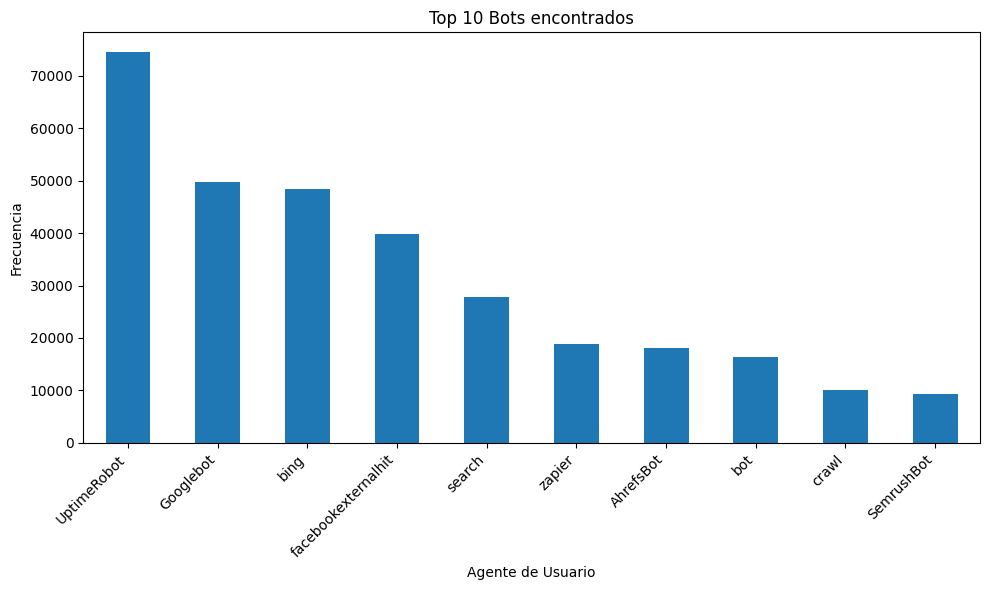

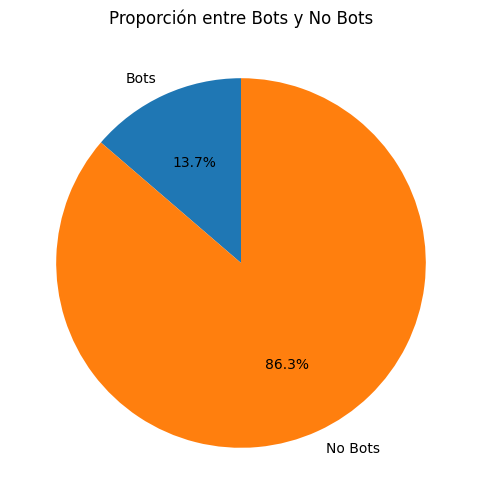

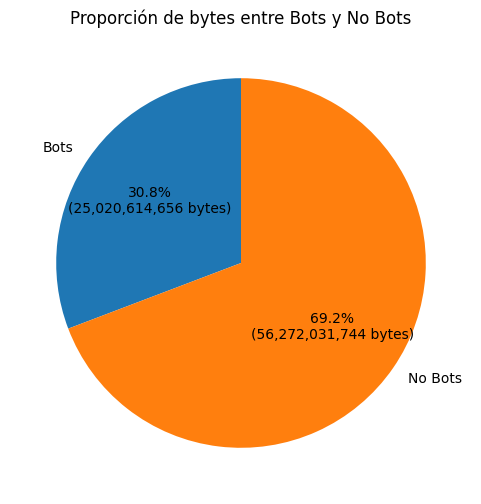

In [45]:
import matplotlib.pyplot as plt

# Tomar el top 10
top_10_bots = frecuencia_bots['frecuencia'].head(10)

# Gráfico de barras
plt.figure(figsize=(10,6))
top_10_bots.plot(kind='bar')

plt.title("Top 10 Bots encontrados")
plt.xlabel("Agente de Usuario")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

""" # Tomar el top 10
top_10_no_bots = frecuencia_no_bots['agente_usuario'].head(10)

# Gráfico de barras
plt.figure(figsize=(10,6))
top_10_no_bots.plot(kind='bar')

plt.title("Top 10 Usuarios normales encontrados")
plt.xlabel("Agente de Usuario")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show() """

# Contar la cantidad de bots y no bots
conteo = [len(df_bots), len(df_no_bots)]
labels = ['Bots', 'No Bots']

# Gráfico de torta
plt.figure(figsize=(6,6))
plt.pie(conteo, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Proporción entre Bots y No Bots")
plt.show() 

# Contar la cantidad de bytes de bots y no bots
conteo = [sum(frecuencia_bots['bytes_enviados']), sum(frecuencia_no_bots['bytes_enviados'])]
labels = ['Bots', 'No Bots']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%\n({v:,} bytes)'.format(p=pct, v=val)
    return my_autopct

# Gráfico de torta
plt.figure(figsize=(6,6))
plt.pie(conteo, labels=labels, autopct=make_autopct(conteo), startangle=90)
plt.title("Proporción de bytes entre Bots y No Bots")
plt.show()

**Creamos colummnas ruta_limpia (aplicando ciertas funciones para normalizar)**

In [8]:
# Lista de extensiones/tipos de recurso a excluir
extensiones_excluir = (
    ".css", ".js", ".png", ".jpg", ".jpeg", ".gif", ".svg",
    ".ico", ".woff", ".woff2", ".ttf", ".eot", ".otf", ".map", ".json", ".xml"
)

# Patrones de WordPress a excluir
wp_rutas_excluir = [
    "/wp-content/",
    "/wp-includes/",
    "/feed",
    "/wp-json/",
    "/xmlrpc.php",
]

def es_contenido(ruta):
    if not isinstance(ruta, str):
        return False  # ignorar valores nulos

    # Excluir si termina con extensión técnica
    if any(ruta.lower().endswith(ext) for ext in extensiones_excluir):
        return False
    # Excluir si contiene rutas técnicas de WP
    if any(pat in ruta for pat in wp_rutas_excluir):
        return False
    # Excluir admin
    if ruta.startswith("/wp-admin"):
        return False
    return True

def normalizar_ruta(ruta):
    if not isinstance(ruta, str):
        return ""
    # Quitar parámetros
    ruta = ruta.split("?")[0]
    # Quitar barra final si no es la raíz
    if ruta != "/" and ruta.endswith("/"):
        ruta = ruta[:-1]
    # Unificar raíz
    if ruta in ["/", "/web"]:
        ruta = "/"
    return ruta


# --- pipeline limpio y consistente ---
df_limpio = df.copy()
df_limpio["ruta_limpia"] = df_limpio["ruta"].map(normalizar_ruta)
df_filtrado = df_limpio[df_limpio["ruta_limpia"].apply(es_contenido)].copy()
df_filtrado['Clasificacion'] = df_filtrado['agente_usuario'].apply(classify_agent)

# Separar bots y no bots

print("Antes:", len(df_limpio), "después:", len(df_filtrado))
print(df_filtrado["ruta_limpia"].head(20))


Antes: 2539371 después: 391476
0                                           /robots.txt
2                                      /web/wp-cron.php
6                                                     /
7     /web/ya-es-posible-tener-paneles-solares-y-ven...
8                           /web/formulario-de-contacto
9     /web/ypf-ha-decidido-ser-un-jugador-en-el-terr...
10                                          /wp-content
11                         /web/category/energias/solar
12                                                    /
13                                                    /
14                                                    /
15                                                    /
17                        /web/sample-page/delegaciones
18    /web/vestas-argentina-es-un-mercado-privilegia...
20                                    /web/wp-login.php
21                                    /web/wp-login.php
22                                                    /
23               

**Creacion columnas origen destino y frecuencia**

In [10]:

df_filtrado = df_filtrado.sort_values(by=["direccion_ip", "timestamp"]) 

# Crear pares de transiciones
transiciones = []
for (ip, clasificacion), grupo in df_filtrado.groupby(["direccion_ip", "Clasificacion"]):
    paginas = grupo["ruta_limpia"].tolist()
    for i in range(len(paginas)-1):
        transiciones.append((paginas[i], paginas[i+1], clasificacion))

# Contar frecuencia de transiciones
df_trans = pd.DataFrame(transiciones, columns=["origen", "destino", "clasificacion"])
#conteo = df_trans.value_counts().reset_index(name="peso")
# Eliminar transiciones donde origen y destino son iguales
conteo = df_trans[
    (df_trans["origen"] != df_trans["destino"]) & 
    (df_trans["destino"] != "/")
].value_counts().reset_index(name="peso")

### **GRAFICOS SANKEY**

**HUMANOS Y BOTS**

In [13]:
import plotly.graph_objects as go

# Filtrar solo las 10 transiciones más frecuentes
top10 = conteo.sort_values("peso", ascending=False).head(80)

# Construir etiquetas únicas y mapearlas a índices
labels = list(pd.unique(top10[["origen", "destino"]].values.ravel()))
mapa = {label: idx for idx, label in enumerate(labels)}

# Mapear origen y destino a índices
source = top10["origen"].map(mapa)
target = top10["destino"].map(mapa)
value = top10["peso"]

# Crear la figura Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Flujo de navegación de usuarios (Top 10 transiciones)", font_size=10)
fig.show(renderer="browser")


**HUMANO**

In [15]:

# Filtrar solo las 10 transiciones más frecuentes
conteo_humanos = conteo[conteo['clasificacion'] == 'Humano']
top10 = conteo_humanos.sort_values("peso", ascending=False).head(80)

# Construir etiquetas únicas y mapearlas a índices
labels = list(pd.unique(top10[["origen", "destino"]].values.ravel()))
mapa = {label: idx for idx, label in enumerate(labels)}

# Mapear origen y destino a índices
source = top10["origen"].map(mapa)
target = top10["destino"].map(mapa)
value = top10["peso"]

# Crear la figura Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Flujo de navegación de usuarios (Top 10 transiciones)", font_size=10)
fig.show(renderer="browser")


**BOTS**

In [16]:

# Filtrar solo las 10 transiciones más frecuentes
conteo_no_humanos = conteo[conteo['clasificacion'] != 'Humano']
# Agrupar por pares origen-destino y sumar el peso, ignorando la columna 'clasificacion'
conteo_no_humanos_agrupado = conteo_no_humanos.groupby(['origen', 'destino'], as_index=False)['peso'].sum()
# Ordenar por peso descendente y tomar el top 80
top10 = conteo_no_humanos_agrupado.sort_values("peso", ascending=False).head(80)

# Construir etiquetas únicas y mapearlas a índices
labels = list(pd.unique(top10[["origen", "destino"]].values.ravel()))
mapa = {label: idx for idx, label in enumerate(labels)}

# Mapear origen y destino a índices
source = top10["origen"].map(mapa)
target = top10["destino"].map(mapa)
value = top10["peso"]


# Crear la figura Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Flujo de navegación de usuarios (Top 10 transiciones)", font_size=10)
fig.show(renderer="browser")


### **INSERCION BASE DE DATOS**

In [26]:
try:
    # Conectar a MySQL
    conexion = mysql.connector.connect(
        host='localhost',  # Cambia según tu servidor
        user='root',  # Reemplaza con tu usuario
        password='1234',  # Reemplaza con tu contraseña
        database='log_analytics'
    )
    cursor = conexion.cursor()
# Insertar datos del DataFrame 'conteo' en la tabla_transiciones
    for _, row in conteo.iterrows():
        cursor.execute("""
            INSERT INTO tabla_transiciones (origen, destino, peso)
            VALUES (%s, %s, %s)
        """, (row['origen'], row['destino'], int(row['peso'])))
    conexion.commit()

except Error as e:
    print(f"Error al conectar o insertar en MySQL: {e}")
finally:
    if conexion.is_connected():
        cursor.close()
        conexion.close()
        print("Conexión a MySQL cerrada.")

Conexión a MySQL cerrada.


### **ANALISIS DE SECUENCIA**

In [ ]:
from funciones.parsear_timestamp import parsear_timestamp
df_secuencias = df_filtrado[['direccion_ip', 'timestamp', 'ruta_limpia','Clasificacion']].copy()
df_secuencias = df_secuencias[df_secuencias['Clasificacion'] == 'Humano']
df_secuencias['timestamp'] = df_secuencias['timestamp'].apply(parsear_timestamp)
# Convertir a datetime
df_secuencias['timestamp'] = pd.to_datetime(df_secuencias['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Ordenar por direccion_ip y timestamp
df_secuencias = df_secuencias.sort_values(by=['direccion_ip', 'timestamp'])
# Nueva función para eliminar repeticiones consecutivas en el DataFrame
def eliminar_repeticiones_consecutivas_df(df):  #si en el flujo aparece ["/", "/", "/productos"], dejarlo como ["/", "/productos"]).
    mask = df['ruta_limpia'] != df['ruta_limpia'].shift()
    return df[mask]

# Aplicar la función por IP para eliminar repeticiones consecutivas
df_filtradoo = (
    df_secuencias
    .groupby('direccion_ip', group_keys=False)
    .apply(eliminar_repeticiones_consecutivas_df)
    .reset_index(drop=True)
 )
sequences1 = df_filtradoo.groupby('direccion_ip')['ruta_limpia'].apply(list).reset_index()
# Agrupar por direccion_ip y crear secuencias con ruta_limpia
sequences = df_secuencias.groupby('direccion_ip')['ruta_limpia'].apply(list).reset_index()

C:\Users\luisd\AppData\Local\Temp\ipykernel_21684\1457991206.py:19: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



**ANALISIS DE ASOCIACIONES SECUENCIALES**

In [59]:
from prefixspan import PrefixSpan

ps = PrefixSpan(sequences1['ruta_limpia'].tolist())
minsupp = int(0.005 * len(sequences1))
patterns = ps.frequent(minsupp)

df_patterns = pd.DataFrame(patterns, columns=["soporte", "subsecuencia"])
df_patterns = df_patterns[df_patterns["subsecuencia"].str.len() == 2]
print(df_patterns)

    soporte                                       subsecuencia
2       729                                             [/, /]
7       125                                   [/, /robots.txt]
8       126                   [/, /web/formulario-de-contacto]
9       249                  [/, /web/sample-page/autoridades]
10      167            [/, /web/sample-page/marco-regulatorio]
11      128                        [/, /web/area-de-concesion]
12      122                 [/, /web/sample-page/delegaciones]
13      192                 [/, /web/buscador-de-resoluciones]
15      130                    [/, /web/resolucion-no-11-2023]
16      208  [/, /web/resolucion-epre-n-13-2023expte-epre-n...
20      135                                   [/robots.txt, /]
25      132  [/web/wp-comments-post.php, /web/wp-comments-p...
26      245  [/web/wp-comments-post.php, /web/resolucion-no...
28      241  [/web/resolucion-no-6714-2, /web/wp-comments-p...
30      215  [/web/resolucion-no-6714-2, /web/resolucio

**ANALISIS DE ASOCIACION**

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
# Convertir dataset a One-Hot Encoding
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(sequences1['ruta_limpia'].tolist()).transform(sequences1['ruta_limpia'].tolist())
df = pd.DataFrame(te_ary, columns=te.columns_)

                  /  /!.php  /%20CSCOE%20/saml/sp/acs  \
0      False  False   False                     False   
1      False  False   False                     False   
2      False  False   False                     False   
3      False   True   False                     False   
4      False   True   False                     False   
...      ...    ...     ...                       ...   
24002  False  False   False                     False   
24003  False  False   False                     False   
24004  False  False   False                     False   
24005  False  False   False                     False   
24006  False  False   False                     False   

       /%20CSCOT%20/oem-customization  /%20CSCOT%20/translation-table  \
0                               False                           False   
1                               False                           False   
2                               False                           False   
3                      

In [63]:
# Buscar itemsets frecuentes con soporte mínimo del 50%
frequent_itemsets = apriori(df, min_support=0.002, use_colnames=True)
frequent_itemsets.sort_values('support', ascending=False, inplace=True)
print(frequent_itemsets)

# Generar reglas de asociación
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules.sort_values('confidence', ascending=False, inplace=True)
print(rules)

ERROR! Session/line number was not unique in database. History logging moved to new session 44
      support                                           itemsets
0    0.226892                                                (/)
68   0.125047  (/web/que-es-la-energia-de-ionizacion-y-por-qu...
55   0.113467  (/web/los-10-aparatos-que-mas-energia-consumen...
56   0.072479  (/web/los-10-artefactos-que-consumen-mas-energ...
36   0.064731  (/web/cuales-son-los-electrodomesticos-que-mas...
..        ...                                                ...
11   0.002041                                         (/web/509)
37   0.002041             (/web/cuanta-energia-consume-internet)
80   0.002041                     (/web/segmentacion-de-tarifas)
110  0.002041  (/, /web/que-es-la-energia-de-ionizacion-y-por...
164  0.002041  (/web/los-8-electrodomesticos-que-consumen-mas...

[189 rows x 2 columns]
                                           antecedents  \
332  (/, /web/sample-page/marco-regulatorio